# Generating Hand-written digits using WGAN

Training a GAN model was difficult, in this model we implements improvements proposed by the two following papers resulting in a more flexible and powerful model.

Papers:
* [WGAN](https://arxiv.org/abs/1701.07875)
* [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf])

In [1]:
!gpustat

phoebe  Fri May  4 12:18:04 2018
[0] GeForce GTX 1080 Ti | 54'C,  41 % | 10844 / 11172 MB | pbjo(7873M)
[1] GeForce GTX 1080 Ti | 68'C, 100 % | 10523 / 11172 MB | valv(10513M)
[2] GeForce GTX 1080 Ti | 48'C,   0 % |  3482 / 11172 MB | valv(2815M) valv(657M)
[3] GeForce GTX 1080 Ti | 75'C,  95 % |  1119 / 11172 MB | valv(1109M)
[4] GeForce GTX 1080 Ti | 75'C,  96 % |  1123 / 11172 MB | valv(1113M)
[5] GeForce GTX 1080 Ti | 68'C,  66 % | 11107 / 11172 MB | valv(11097M)
[6] GeForce GTX 1080 Ti | 63'C,  61 % | 11091 / 11172 MB | valv(11081M)
[7] GeForce GTX 1080 Ti | 67'C,  19 % | 10399 / 11172 MB | valv(10389M)


In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

For this experiment, we will use the traditional MNIST dataset.

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = 'MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
L = 28

## Wasserstein GAN 

In this paper, the author argues that the loss function used in the original paper may not always be continuous and is biased. The Wassertein paper proposes to use the **Earth Mover** metric also named the Wassertein-1 metric as a loss function which in many way a better metric for GANs. In particular, this paper states a theorem saying that if $f$ is Lipschitz continous, then the Wassertein metric is continous. In order to ensure that the discriminator $D$ is Lipschitz, the authors propose to bound the weights of the neural network.

Last the paper re-write (see theorm in the paper) the Wassertein distance as:

$\max_{||f||_L < 1} \mathbb{E}_{x \sim \mathcal{P}_r} [f(x] - \mathbb{E}_{x \sim \mathcal{P}_\theta} [f(x]$

### Multi-Layer Perceptron

In [34]:
class MLP(nn.Module):
    def __init__(self, num_hidden_features,dropout=0,activation=nn.Tanh, batch_norm = False):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(num_hidden_features) - 2):
            in_features = num_hidden_features[i]
            out_features = num_hidden_features[i+1]
            if batch_norm:
                layers += [ nn.Linear(in_features=in_features, out_features=out_features), nn.BatchNorm1d(out_features),nn.Dropout(dropout), activation()]
            else:
                layers += [ nn.Linear(in_features=in_features, out_features=out_features), nn.Dropout(dropout), activation()]
        in_features = num_hidden_features[i]
        out_features = num_hidden_features[i+1]
        layers += [ nn.Linear(in_features=num_hidden_features[-2], out_features=num_hidden_features[-1])]
        self.mlp = nn.Sequential(*layers)
    def forward(self, x):
        return self.mlp(x)

### Some Utilities

In [46]:
def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.conv.weight is not None:
            if m.he_init:
                init.kaiming_uniform_(m.conv.weight)
            else:
                init.xavier_uniform_(m.conv.weight)
        if m.conv.bias is not None:
            init.constant_(m.conv.bias, 0.0)
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

#### WGAN-GP: gradients penalty

In the case of a function $f$ with real values, $f$ is said to be Lipschitz continous if

$\forall x_1,x_2 \in \mathcal{R}^2, \exists K \geqslant 0 \mid |f(x_{1})-f(x_{2})|\leq K|x_{1}-x_{2}|$

According to the theorem stated in the Original WGAN paper, $f$ (here the neural networks) needs to be continous and locally Lipschitz. In order to quarantee the Lipschitz condition, weights of the $D$ model are confined into a fixed range. In practice, one would clip the weights of $D$ after a training step in range [-0.01,0.01]. However, limiting this range limits the the modeling power of the model because weights cannot grow freely.

The WGAN-GP paper brings a solution to this problem by adding a penaly on the gradients of $f$ in order to bound them. Indeed, if $f'$ is bounded , then $f$ is Lipschitz. The paper argues, that this improves significantly the results (which I observed as well from these small experiments). However, be careful not to use batch normalization in $D$.

*Implementation inspired from [This Github](https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py)*

In [47]:
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device) 

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

## Training

In [48]:
batch_size = 128
m = int(np.sqrt(batch_size))-1
lr = 1e-3
dropout = 0.2
noise_dim = 64
num_layers = 2
n_out = L**2
clipping_value = 1e-2

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
generator = MLP([noise_dim,256,512,512,512,n_out],dropout=0,activation=nn.ReLU, batch_norm=True)
generator = nn.Sequential(generator, nn.Tanh()).to(device)
discriminator = MLP([n_out,512,512,256,1],dropout=dropout,activation=nn.ReLU, batch_norm=False).to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)
# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0,0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=lr)#, betas=(0,0.9)) #RMSprop
loss = nn.BCELoss()

# data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

#### Training $D$

In [49]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    #loss_real = - prediction_real.mean()
    
    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    #loss_fake = prediction_fake.mean()
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_data, fake_data)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    
    
        
    # Return error and predictions for real and fake inputs
    return loss

#### Training $G$

In [50]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    G_loss = - torch.mean(prediction)
    G_loss.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return G_loss

#### Full Training

The discrimator is trained more steps than the generator

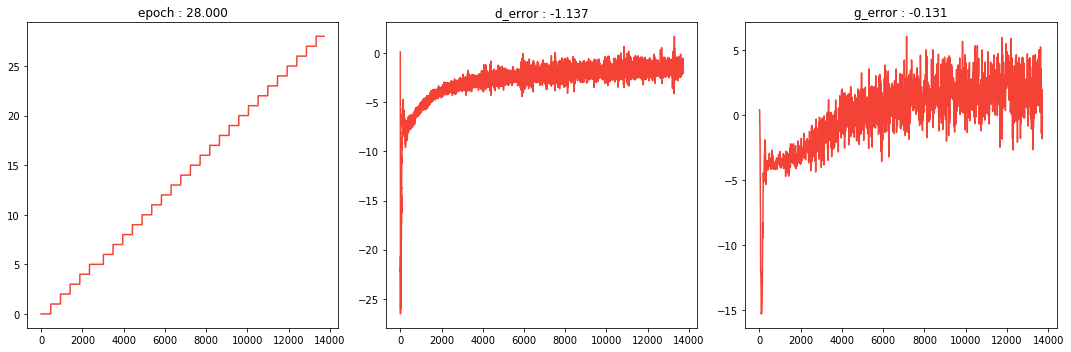

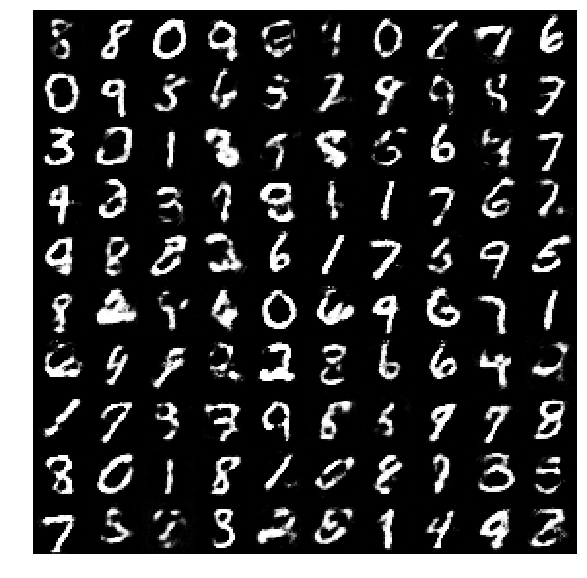

In [52]:
gen_steps = 1
gen_train_freq = 8
try:
    while True:
        for n_batch, (real_batch,_) in enumerate(data_loader):
            N = real_batch.size(0)
            
            # 1. Train Discriminator
            real_data = images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)
            with torch.no_grad():
                fake_data = generator(noise_tensor).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data, fake_data)

            # 2. Train Generator
            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    
                    # Generate fake data
                    fake_data = generator(noise(N,noise_dim))
                    # Train G
                    g_error = train_generator(g_optimizer, fake_data)
                    g_error = g_error.item()
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            # Display Progress every few batches
            if global_step % 50 == 0:
                test_images = vectors_to_images(generator(test_noise))
                test_images = test_images.data
                L = 28
                canvas = np.zeros((L*m,L*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
                        q+=1
                dis.display(scale=True)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                if False:#epoch % 50 == 0:
                    plt.savefig("GAN-MNIST-Epoch="+str(epoch)+".png")
                plt.show()
        epoch+=1
except:
    test_images = vectors_to_images(generator(test_noise))
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
            q+=1
    dis.display(scale=False)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("WGAN-GP-MNIST.png")
    plt.show()

## Conclusion

Changing the loss function of the GAN network as described in the WGAN paper and asserting the Lipschitz condition using constrains on the gradients as proposed by the WGAN-GP papers allow us to build a more flexible and powerful model. While finding hyperparameters for the GAN model was a difficult task, the WGAN-GP model converges for a wide range of architectures.